In [1]:
# Import Libraries and Dependencies 
import pandas as pd
import numpy as np 
import os
import json
from pathlib import Path
from datetime import datetime, timedelta
from tiingo import TiingoClient
%matplotlib inline

In [2]:
# Bring Env Variables into Python/Store in Variable
tiingo = os.getenv('TIINGO_API_KEY')

In [3]:
# Create a Client to Connect to Tiingo
client = TiingoClient()

# Data Collection for US Stocks

In [4]:
# Create Start and End Dates for 1 Year's Worth of Historical Data
end = datetime.now()
start = end + timedelta(-365)

In [5]:
# Create DataFrames for China
us_ticker_df = client.get_dataframe(['SPY','IGM', 'IYE', 'IYM', 'IYH', 'IECS'],
                                            metric_name='close',
                                            startDate= start,
                                            endDate= end,
                                            frequency='daily')

C:\Users\selva\Anaconda3\lib\site-packages\tiingo\api.py:270: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  prices = pd.concat([prices, df[stock]], axis=1)


In [6]:
us_df = us_ticker_df.rename(columns={'IGM':'IGM (Technology)', 'IYE':'IYE (Energy)', 'IYM':'IYM (Materials)', 'IYH':'IYH (Healthcare)', 'IECS':'IECS (Consumer Staples)'})
us_df.head()

,SPY,IGM (Technology),IYE (Energy),IYM (Materials),IYH (Healthcare),IECS (Consumer Staples)
date,,,,,,
2019-02-06 00:00:00+00:00,272.74,193.7109,35.16,89.50,191.0895,24.5705
2019-02-07 00:00:00+00:00,270.14,190.7848,34.36,87.83,189.0200,24.5157
2019-02-08 00:00:00+00:00,270.47,191.5262,34.20,87.58,189.2100,24.6313
2019-02-11 00:00:00+00:00,270.62,191.8665,34.39,87.92,189.1700,24.7325
2019-02-12 00:00:00+00:00,274.10,194.7900,34.83,89.89,191.6600,24.9152


# Monte Carlo Simulation 

In [7]:
# Calculate the Daily Returns for China Stocks
us_daily_returns = us_df.pct_change()
us_daily_returns.head()

,SPY,IGM (Technology),IYE (Energy),IYM (Materials),IYH (Healthcare),IECS (Consumer Staples)
date,,,,,,
2019-02-06 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-07 00:00:00+00:00,-0.009533,-0.015106,-0.022753,-0.018659,-0.010830,-0.002230
2019-02-08 00:00:00+00:00,0.001222,0.003886,-0.004657,-0.002846,0.001005,0.004715
2019-02-11 00:00:00+00:00,0.000555,0.001777,0.005556,0.003882,-0.000211,0.004109
2019-02-12 00:00:00+00:00,0.012859,0.015237,0.012794,0.022407,0.013163,0.007387


In [9]:
# Calculate the Value of Average Daily Returns
avg_daily_returns_spy = us_daily_returns.mean()['SPY']
avg_daily_returns_igm = us_daily_returns.mean()['IGM (Technology)']
avg_daily_returns_iye = us_daily_returns.mean()['IYE (Energy)']
avg_daily_returns_iym = us_daily_returns.mean()['IYM (Materials)']
avg_daily_returns_iyh = us_daily_returns.mean()['IYH (Healthcare)']
avg_daily_returns_iecs = us_daily_returns.mean()['IECS (Consumer Staples)']

In [10]:
# Calculate the Standard Deviation 
std_daily_returns_spy = us_daily_returns.std()['SPY']
std_daily_returns_igm = us_daily_returns.std()['IGM (Technology)']
std_daily_returns_iye = us_daily_returns.std()['IYE (Energy)']
std_daily_returns_iym = us_daily_returns.std()['IYM (Materials)']
std_daily_returns_iyh = us_daily_returns.std()['IYH (Healthcare)']
std_daily_returns_iecs = us_daily_returns.std()['IECS (Consumer Staples)']

In [11]:
# Save the Last Day's Closing Price
spy_last_price = us_df['SPY'][-1]
igm_last_price = us_df['IGM (Technology)'][-1]
iye_last_price = us_df['IYE (Energy)'][-1]
iym_last_price = us_df['IYM (Materials)'][-1]
iyh_last_price = us_df['IYH (Healthcare)'][-1]
iecs_last_price = us_df['IECS (Consumer Staples)'][-1]

In [12]:
# Setup the Monte Carlo Parameters
number_simulations = 100
number_records = 252
monte_carlo = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [13]:
# Run the Monte Carlo Simulation
for x in range (number_simulations):
    simulated_spy_prices = [spy_last_price]
    simulated_igm_prices = [igm_last_price]
    simulated_iye_prices = [iye_last_price]
    simulated_iym_prices = [iym_last_price]
    simulated_iyh_prices = [iyh_last_price]
    simulated_iecs_prices = [iecs_last_price]
    
    for y in range (number_records):
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_returns_spy, std_daily_returns_spy))
        simulated_igm_price = simulated_igm_prices[-1] * (1 + np.random.normal(avg_daily_returns_igm, std_daily_returns_igm))
        simulated_iye_price = simulated_iye_prices[-1] * (1 + np.random.normal(avg_daily_returns_iye, std_daily_returns_iye))
        simulated_iym_price = simulated_iym_prices[-1] * (1 + np.random.normal(avg_daily_returns_iym, std_daily_returns_iym))
        simulated_iyh_price = simulated_iyh_prices[-1] * (1 + np.random.normal(avg_daily_returns_iyh, std_daily_returns_iyh))
        simulated_iecs_price = simulated_iecs_prices[-1] * (1 + np.random.normal(avg_daily_returns_iecs, std_daily_returns_iecs))
       
        simulated_spy_prices.append(simulated_spy_price)
        simulated_igm_prices.append(simulated_igm_price)
        simulated_iye_prices.append(simulated_iye_price)
        simulated_iym_prices.append(simulated_iym_price)
        simulated_iyh_prices.append(simulated_iyh_price)
        simulated_iecs_prices.append(simulated_iecs_price)
    
    monte_carlo['ASHR prices'] = pd.Series(simulated_spy_prices)
    monte_carlo['IGM (Technology) prices'] = pd.Series(simulated_igm_prices)
    monte_carlo['IYE (Energy) prices'] = pd.Series(simulated_iye_prices)
    monte_carlo['IYM (Materials) prices'] = pd.Series(simulated_iym_prices)
    monte_carlo['IYH (Healthcare) prices'] = pd.Series(simulated_iyh_prices)
    monte_carlo['IECS (Consumer Staples) prices'] = pd.Series(simulated_iecs_prices)
    
    simulated_us_daily_returns = monte_carlo.pct_change()
    
    weights = [(100/6), (100/6), (100/6), (100/6), (100/6), (100/6)]
    us_portfolio_daily_returns = simulated_us_daily_returns.dot(weights)
    
    portfolio_cumulative_returns[x] = (1 + us_portfolio_daily_returns.fillna(0)).cumprod()
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.645786,1.123815,1.018501,1.070702,0.724522,1.032522,1.403808,1.129222,0.607329,0.509038,...,0.979150,0.619988,0.914790,0.709055,1.289603,0.695116,1.581106,1.204892,1.050671,0.939516
2,0.383980,1.302609,1.080911,0.629432,0.835017,0.965083,1.904342,1.853586,0.329276,0.672214,...,0.765236,0.601554,1.558141,0.639285,1.011503,0.664131,1.467446,0.415482,0.567445,0.745063
3,0.442381,0.037208,1.568329,0.865582,0.692781,1.128508,0.068009,2.279805,0.625412,0.557126,...,1.388740,0.348569,1.213859,1.035013,1.365475,0.748273,1.943099,0.086865,0.599177,0.586876
4,0.466658,0.026092,1.425787,0.972177,0.654397,1.660926,0.100124,2.708330,0.452392,0.618660,...,0.637293,0.505040,1.199817,0.675132,1.342667,0.869571,0.845784,0.077093,0.810452,0.584174


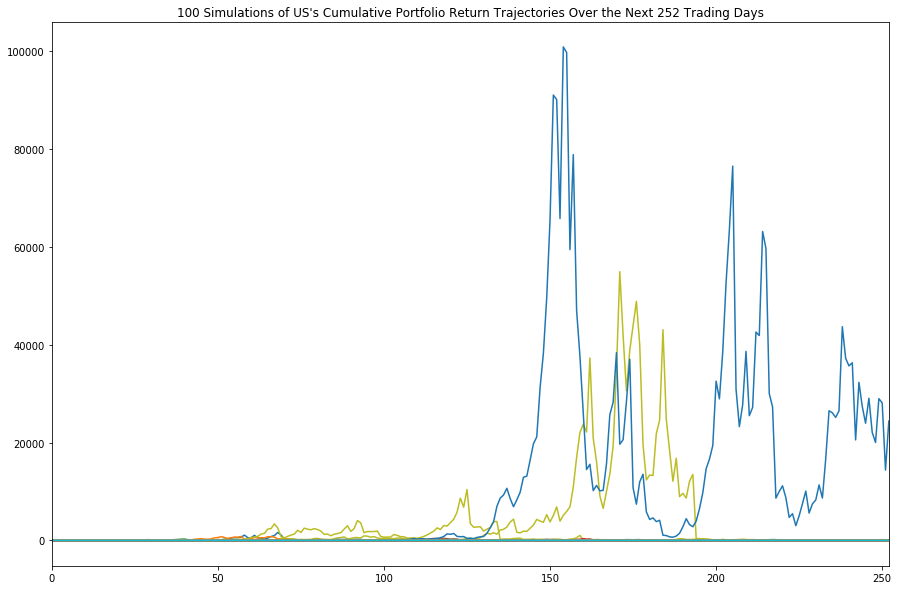

In [14]:
# Visualize the Simulation
plot_title = f"{number_simulations} Simulations of US's Cumulative Portfolio Return Trajectories Over the Next {number_records} Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title, figsize=(15,10))